In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.preprocessing import*
import datetime,time
from sklearn.metrics import*
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA

In [2]:
train_all_v1 = pd.read_csv('../../../../homecredit/train_all_v1.csv')

In [3]:
start_time = time.time()

obj_columns = train_all_v1 .select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
train_all_v1  = pd.get_dummies(train_all_v1 , columns = obj_columns, drop_first = True)

X= train_all_v1.drop(columns= ['Unnamed: 0','TARGET','SK_ID_CURR']).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_all_v1['TARGET']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)


end_time = time.time()  
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time,2), "秒")
print("done時間:", datetime.datetime.now())    


程式執行花費的時間： 0.88 秒
done時間: 2023-09-02 10:57:30.971097


In [8]:
# start_time = time.time()

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)
# X_val = np.array(X_val)
# y_val = np.array(y_val)

# end_time = time.time()  
# execution_time = end_time - start_time
# print("\n程式執行花費的時間：", round(execution_time,2), "秒")
# print("done時間:", datetime.datetime.now())  


程式執行花費的時間： 0.21 秒
done時間: 2023-09-01 16:16:27.804217


In [4]:
start_time = time.time()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

end_time = time.time()  
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time,2), "秒")
print("done時間:", datetime.datetime.now()) 


程式執行花費的時間： 0.51 秒
done時間: 2023-09-02 10:57:34.185238


In [10]:
# pca = PCA(n_components=0.95)  # 選擇解釋變異量為95%的主成分
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
# X_val_pca = pca.transform(X_val_scaled)

# # 打印保留的主成分數量
# print("保留的主成分數量:", pca.n_components_)

保留的主成分數量: 60


c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 22380, number of negative: 254379
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8282
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 156
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017109 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080865 -> initscore=-2.430658
[LightGBM] [Info] Start training from score -2.430658

程式執行花費的時間： 5.0 秒
Validation AUC: [0.7104708811893655, 0.72376997703916, 0.7262949952590562, 0.7285273181889754, 0.7309496959465559, 0.7323632376544064, 0.733390813515792, 0.7348428632512521, 0.7353686349486975, 0.7363006263439245, 0.7364420033681384, 0.7379603566140451, 0.73

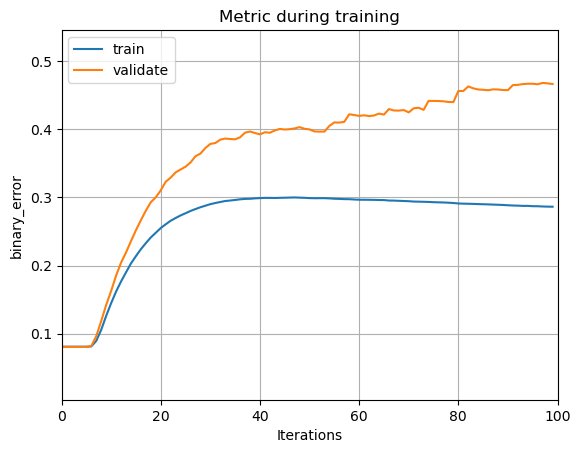

In [30]:
params = {
    'objective': 'binary',
    'is_unbalance': 'true',
    'device': 'gpu',
    'num_iteration': 100,
    'metric': 'auc',  
    'verbosity': 1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


evals_result = {} 


start_time = time.time()
gbm = lgb.train(params, lgb_train, valid_sets=(lgb_eval, lgb_train), valid_names=('validate', 'train'), callbacks=[lgb.record_evaluation(evals_result)])

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


auc_val = evals_result['validate']['auc'] 
auc_train = evals_result['train']['auc']


end_time = time.time()
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time, 2), "秒")
print("Validation AUC:", auc_val)
print("Train AUC:", auc_train)
print("Validation ACC:", acc_val)
print("Train ACC:", acc_train)
print("完成時間:", datetime.datetime.now())

# 绘制记录的评估指标
lgb.plot_metric(evals_result, metric='auc')  
plt.show()


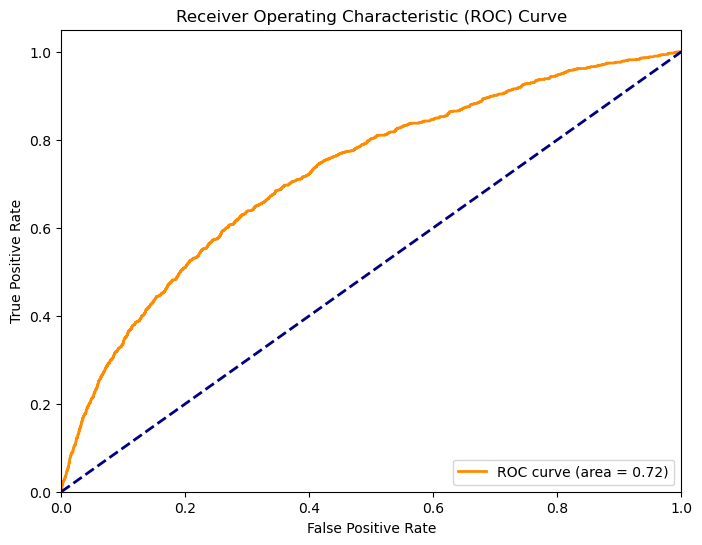

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 計算AUC曲線上的點
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# 繪製AUC曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0]) # 實際沒違約，預測正確
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) # 實際違約，預測卻沒有

NameError: name 'y_pred' is not defined

<Axes: >

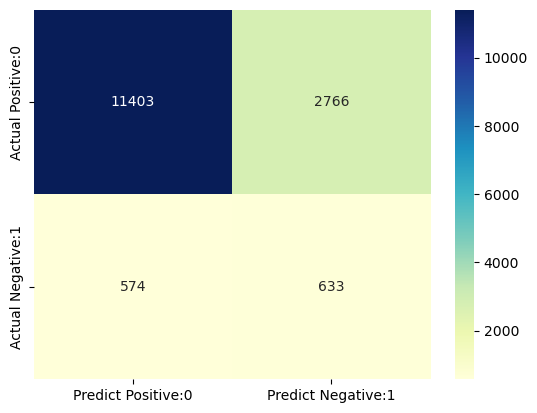

In [10]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28300
           1       1.00      0.00      0.00      2452

    accuracy                           0.92     30752
   macro avg       0.96      0.50      0.48     30752
weighted avg       0.93      0.92      0.88     30752

